In [1]:
import tensorflow as tf
import numpy as np

from pinn import PINNModel, model1
from accuracy import AccuracyCalc
from plotting import NNPlots
from data_gen import DataGenerator

2024-10-11 19:57:32.830704: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 19:57:32.841702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 19:57:32.853794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 19:57:32.857439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 19:57:32.867012: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [3]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
area_grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 6000
EPRINT = 500
LOSS = 1e-4

model = PINNModel(model1(4), optm = tf.keras.optimizers.Adam(learning_rate=0.001))

dataGen = DataGenerator(x_limits, y_limits, model.predict, real_u)
plotter = NNPlots(dataGen, (200, 200))
acc = AccuracyCalc(dataGen, (70, 70))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1728665856.758238   88171 service.cc:146] XLA service 0x72556c003a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728665856.758256   88171 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-11 19:57:36.777341: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step

I0000 00:00:1728665857.165387   88171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [6]:
for k in range(1, 10):
    model.reset_weights()
    model.train(k, dataGen.inner_pairs(area_grid_size), dataGen.border_pairs(border_grid_size), EPOCHS, LOSS, EPRINT)
    
    acc.update((70, 70))
    plotter.update((200, 200))

    print("Error:", acc.mse())
    print("Error:", acc.maxe())

    model.save(f"../models/model{k}.weights.h5")

epoch: 0 loss: 101.740829
epoch: 500 loss: 0.306376904
epoch: 1000 loss: 0.089804858
epoch: 1500 loss: 0.0385287479
epoch: 2000 loss: 0.0237469506
epoch: 2500 loss: 0.0111700268
epoch: 3000 loss: 0.00652412465
epoch: 3500 loss: 0.00437701587
epoch: 4000 loss: 0.00244399579
epoch: 4500 loss: 0.0146662267
epoch: 5000 loss: 0.00268846191
epoch: 5500 loss: 0.00201538112
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
Error: 0.4849034547223827
Error: 1.9982590477828333


In [7]:
print("Error:", acc.mse())
print("Error:", acc.maxe())

Error: 0.4849034547223827
Error: 1.9982590477828333


/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:77: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:98: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(
/home/c0c0nut/Projects/PINN_Poisson/src/plotting.py:128: UserWarning: The following kwargs were not used by contour: 'linestyle'
  diff.contour(


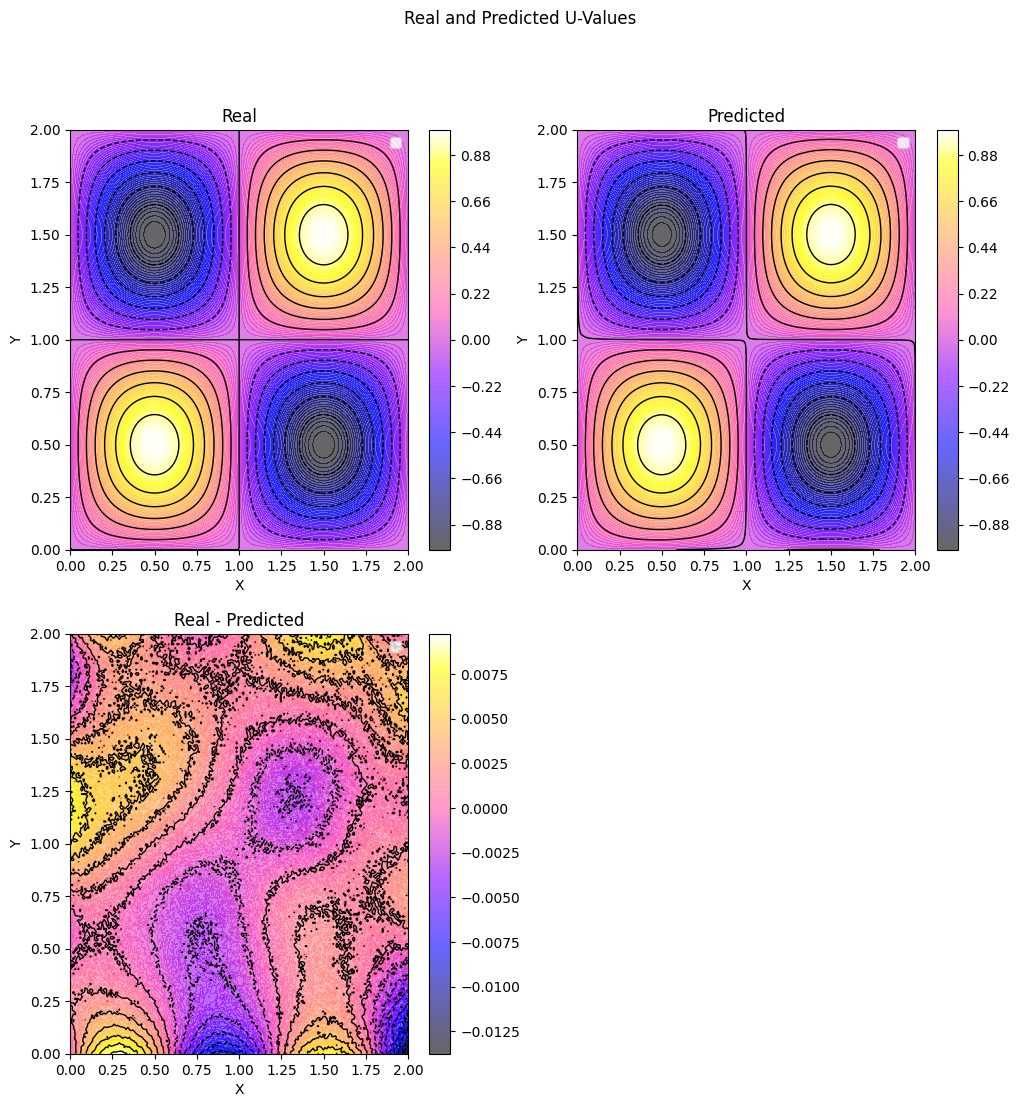

In [8]:
plotter.plot2d_contour(color_map="gnuplot2")